<a href="https://colab.research.google.com/github/lhandley1/ZeroWasteCook-Food-Classifier/blob/main/food_class_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ZeroWasteCook** - Fine-tuning InceptionV3 for Food Image Classification

This notebook explores the process of fine-tuning the powerful InceptionV3 deep learning model to classify food images using a custom dataset.

InceptionV3, a state-of-the-art convolutional neural network (CNN) developed by Google, is renowned for its exceptional performance in object recognition tasks. Its intricate architecture, comprising 48 layers, was initially trained on the massive ImageNet dataset, which encompasses over a million images across 1000 diverse categories. To utilize InceptionV3 effectively, our dataset images will be preprocessed to match its standard input size of 299x299 pixels.

https://www.kaggle.com/datasets/imsparsh/inception-v3-model

# Food Classification Dataset

This section introduces the dataset used for fine-tuning the InceptionV3 model. Provided by **Bjorn** on Kaggle, this dataset contains a collection of images featuring various food items. We will leverage this data to train our model to accurately classify different food ingredients.

**Dataset Link:** https://www.kaggle.com/datasets/bjoernjostein/food-classification

# Import and download necessary libraries

In [ ]:
#Required PyTorch imports
import torch
import torch.nn as nn #Includes all the nessary functions for neural networks
import torch.optim as optim #Required to determine the optimization algorithms e.g. Adam
from torchvision import transforms, models #Required to preprocess the images and load InceptionV3 model
from torchvision.models import Inception_V3_Weights #Required to allow for future compatibility
import torchvision.transforms as transforms #Needed to preprocess the images
import torchvision.models as models #Needed to load the InceptionV3 model
from torchvision.datasets import ImageFolder #Required to define the images directory
from torch.utils.data import Dataset, DataLoader #Required to load the data
import torchvision.utils #Required to visualise images

#Required imports for data extraction and sampling
import os
import pandas as pd
from PIL import Image #Required to collect an image and convert it into a different format

#Visualisation and data manipulation
import matplotlib.pyplot as plt
import numpy as np

#Training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Upload Dataset file

In [ ]:
from google.colab import files
uploaded = files.upload()  # Opens a file upload dialog

Saving archive.zip to archive.zip


#Extract the zip file


In [ ]:
import zipfile

zip_path = "/content/archive.zip"  # Change to your ZIP file path
extract_to = "/content"

zipfile.ZipFile(zip_path).extractall(extract_to)

print("Extraction complete!")

Extraction complete!


# Extract food classification dataset and display summary

In [ ]:
fd_dataset_file = pd.read_csv('/content/food_class_dataset/train_img.csv')
fd_imgs_dir = '/content/food_class_dataset/train_images/train_images'

#Summary of images with their ingredient class names
print(f"\nSummary of data:\n {fd_dataset_file.head()}\n")

#Get all the class names for evaulation later
class_names = fd_dataset_file['ClassName'].unique()


Summary of data:
           ImageId               ClassName
0  f27632d7e5.jpg                   water
1  efa87919ed.jpg  pizza-margherita-baked
2  4f169e8c8d.jpg                broccoli
3  a6956654bf.jpg  salad-leaf-salad-green
4  d99ce8c3bf.jpg                     egg



# Custom Dataset Class

In [ ]:
class IngredientsDataset(Dataset):
  def __init__(self, labels_file, images_dir, transform=None, train=True):
    self.images_labels = labels_file
    self.images_dir = images_dir
    self.transform = transform
    self.train = train

  def __len__(self):
    return len(self.images_labels) #Display the size of the dataset

  def __getitem__(self, idx):
    #Collect the image associated with the index of the training csv file
    img_location = os.path.join(self.images_dir, self.images_labels.iloc[idx, 0])
    image = Image.open(img_location).convert('RGB') #Converted to RGB format so its in the right format for the model
    label = self.images_labels.iloc[idx, 1] #Row index and column 1 to fetch the label
    if self.transform:
      image = self.transform(image) #Defines the images that needs to be preprocessed
    if self.train:
      label = self.images_labels.iloc[idx, 1]
      return image, label #Displays the image file and its related label
    else:
      return image #Displays just the image if the label cannot be found

  @property
  def classes(self):
    return self.images_labels['ClassName'].unique() #Display the number of unique classifications

#Preprocess/Transform Function

* ``` transforms.Resize() ``` - resize images to 299X299 as it is the standard image input size InceptionV3 was trained on.
*   ``` transforms.CenterCrop() ``` - ensure the images are cropped to be a square ratio 299x299.
*   ``` transforms.ToTensor() ``` - converts the image to Tensor.
*   ``` transforms.Normalize() ``` - used to normalise the distribution of the pixels to match ImageNet.
  *  **mean** - the mean values of the R, G, B channels.
  *  **std** - the stardard deviation values of the R, G, B channels.



In [ ]:
#Preprocess parameters
image_resize = 299
crop_size = 299
#Normalisation ranges
mean = np.array([0.485, 0.456, 0.406])
stand_dev = np.array([0.229, 0.224, 0.225])

#Preprocess of images before they are loaded
preprocess = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=stand_dev),
])

#Define the training and validation split ratio
* 60% train, 40% validation

In [ ]:
val_ratio = 0.4
train_set, val_set = train_test_split(fd_dataset_file, test_size=val_ratio, random_state=34)

# Create new Custom Dataset Instance and display details

In [ ]:
#Create train IngredientsDataset Instance
train_dataset = IngredientsDataset(train_set, fd_imgs_dir, preprocess)

#Crate validation IngredientsDatset Instance
val_dataset = IngredientsDataset(val_set, fd_imgs_dir, preprocess)

#Display details on the training dataset
print("TRAINING DATASET")

#Get the length of the train dataset
print(f"\nLength of training dataset: {len(train_dataset)}")

#Get all of the ingredient classes
print(f"\nIngredient Classes: {train_dataset.classes}")

#Get the number of ingredient classes
print(f"\nNumber of Ingredient Classes: {len(train_dataset.classes)}")

#Display an image details
image, label = train_dataset.__getitem__(12)
print(f"\nFood Label: {label}")

#Check that the images have been transformed to the correct size
print(f"\nImage Size: {image.shape}")

#Display details on the validation dataset
print(f"\nVALIDATION DATASET:")

#Get the length of the train dataset
print(f"\nLength of validation dataset: {len(val_dataset)}")

#Display an image details
image, label = val_dataset.__getitem__(12)
print(f"\nFood Label: {label}")

#Check that the images have been transformed to the correct size
print(f"\nImage Size: {image.shape}")

TRAINING DATASET

Length of training dataset: 5593

Ingredient Classes: ['tomato-sauce' 'pizza-margherita-baked' 'egg' 'butter' 'potatoes-steamed'
 'boisson-au-glucose-50g' 'water' 'chips-french-fries' 'mixed-vegetables'
 'tea' 'mixed-nuts' 'coffee-with-caffeine' 'bread-wholemeal' 'bread-white'
 'carrot' 'zucchini' 'salad-leaf-salad-green' 'dark-chocolate'
 'white-coffee-with-caffeine' 'hard-cheese' 'avocado' 'chicken'
 'bread-french-white-flour' 'tomato' 'apple' 'onion' 'almonds' 'honey'
 'salami' 'cucumber' 'rice' 'banana' 'wine-red' 'pasta-spaghetti' 'beer'
 'jam' 'cheese' 'wine-white' 'mandarine' 'espresso-with-caffeine'
 'tea-green' 'croissant' 'biscuits' 'leaf-spinach'
 'mixed-salad-chopped-without-sauce' 'soft-cheese' 'bread-whole-wheat'
 'mayonnaise' 'broccoli' 'french-beans' 'ham-raw' 'sweet-pepper' 'salmon'
 'gruyere' 'sauce-savoury' 'strawberries' 'bread-sourdough' 'pickle'
 'parmesan' 'corn' 'water-mineral']

Number of Ingredient Classes: 61

Food Label: bread-wholemeal

Im

# DataLoader - Load the training dataset using

In [ ]:
#Determines the batch size
b_size = 32

#Creating DataLoaders - Loads data into batches of 32 images and shuffles than randomly
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=b_size, shuffle=True)

#Display change in shape for train dataset
for images, labels in train_loader:
  print(f"Image: {images.shape}, Label: {labels}") #Display labels and images to ensure their formatted corectly
  break
print(f"\n Shape of training images: {images.shape}")
print(f"\n Groupings of training labels: {len(labels)}")

Image: torch.Size([32, 3, 299, 299]), Label: ('rice', 'espresso-with-caffeine', 'water', 'butter', 'bread-wholemeal', 'water', 'mixed-vegetables', 'salad-leaf-salad-green', 'bread-wholemeal', 'mixed-nuts', 'water', 'mixed-salad-chopped-without-sauce', 'wine-white', 'banana', 'espresso-with-caffeine', 'apple', 'salad-leaf-salad-green', 'bread-white', 'sweet-pepper', 'white-coffee-with-caffeine', 'cheese', 'soft-cheese', 'bread-white', 'mixed-vegetables', 'coffee-with-caffeine', 'chicken', 'water', 'soft-cheese', 'bread-wholemeal', 'tea', 'apple', 'tomato-sauce')

 Shape of training images: torch.Size([32, 3, 299, 299])

 Groupings of training labels: 32


#Display a batch sample of images

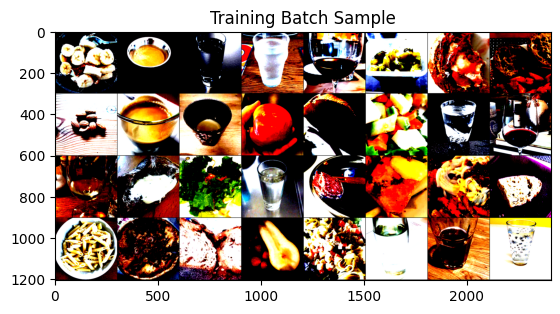

In [ ]:
plt.ion() #Use interactive mode

def imshow(input, title=None):
  """Display images when they are in tensor format"""
  input = input.numpy().transpose((1, 2, 0))
  img = stand_dev * input + mean #Return to non normalised value
  input = np.clip(input, 0, 1) #Set an upper and lower limit
  plt.imshow(input) #Display the images
  if title is not None:
    plt.title(title) #Display a title
  plt.pause(0.001) #Add a short pause when updating the plot

inputs, classes = next(iter(train_loader))

#Display a grid from a batch of input images
map = torchvision.utils.make_grid(inputs)

imshow(map, title="Training Batch Sample")


# Assign Hyperparameters for the model

In [ ]:
#Determined earlier how many classes there was in the dataset
amount_classes = 61
#Set to a minimum amount as neural networks are sensitive
learning_rate = 0.001
#High volume of images so adding more epochs would be computationally expensive
num_epochs = 6

#Create inception v3 model class

In [ ]:
#Convolutional Neural Network class
class InceptionV3Network(nn.Module):
  def __init__(self, num_classes=61, aux_logits=True):
    super().__init__()
    self.inceptionV3 = models.inception_v3(weights=Inception_V3_Weights.DEFAULT) #Load in inception V3 model
    self.inceptionV3.fc = nn.Linear(2048, num_classes) #Changes the final classifier to output up to 51 food ingredient types
    self.aux_logits = aux_logits #Added an additional classifer to reduce overfitting and generalise predictions

  def forward(self, x):
    outputs = self.inceptionV3(x) #Return outputs
    if self.training and self.aux_logits and self.inceptionV3.aux_logits:
      return outputs.logits, outputs.aux_logits #Return both classifier outputs in training mode
    else:
      return outputs #Return only the main classifer outputs in eval mode

#Display the network structure
model1 = InceptionV3Network(amount_classes)
print(model1)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 81.4MB/s] 


InceptionV3Network(
  (inceptionV3): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4

#Train the InceptionV3 model function

In [ ]:
def train(model, loss, learning_rate, loader, class_names, epochs):
  #Average losses
  avg_epoch_main_loss = []
  avg_epoch_aux_loss = []
  avg_epoch_loss_total = []

  #Adam (Adaptive Moment Estimation) regularly used optimiser for deep learning, where the learning rate is adapted for each parameter
  optimiser = optim.Adam(model.parameters(), lr=learning_rate) #Learning rate predefined

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train() #Set the model to train mode

    #Store all the losses
    epoch_main_loss = 0.0
    epoch_aux_loss = 0.0
    epoch_loss_total = 0.0
    #Store total number of batches
    total_batches = 0

    for i, train_batch in enumerate(loader, 0):
      images, labels = train_batch #Collect the images and labels from the current data batch
      optimiser.zero_grad() #Zero the parameter gradients
      outputs = model(images) #Collect outputs from both the classifiers

      #Iterates through each class label to link it to a numeric number
      label_to_numerics = {label: i for i, label in enumerate(class_names)}

      #Assigns each label a numeric value using label_to_numerics mapping
      #e.g. label = 'apple' becomes label = 0
      num_labels = [label_to_numerics[label] for label in labels]

      #Convert label numbers to tensor format
      labels_tensor = torch.tensor(num_labels, dtype=torch.long)

      if isinstance(outputs, tuple):
        main_outputs, aux_outputs = outputs
        #Determine each classifers loss
        main_loss = loss(main_outputs, labels_tensor)
        aux_loss = loss(aux_outputs, labels_tensor)
        #Determine overall loss (auxilary weight worth less as its not the main classifier)
        total_loss = main_loss + 0.4 * aux_loss
      else:
        main_outputs = outputs
        main_loss = loss(main_outputs, labels_tensor)
        aux_loss = 0.0
        total_loss = main_loss

      total_loss.backward() #Perform the backward pass
      optimiser.step() #Update the models weights accordingly

      #Sum up all the losses
      epoch_main_loss += main_loss.item()
      #Stores the Auxilary loss as 0 if it is not part of the current layer
      epoch_aux_loss += aux_loss if isinstance(aux_loss, float) else aux_loss.item()
      epoch_loss_total += total_loss.item()
      total_batches += 1

    #Calculate the average loss per epoch
    avg_epoch_main_loss.append(epoch_main_loss / total_batches)
    avg_epoch_aux_loss.append(epoch_aux_loss / total_batches)
    avg_epoch_loss_total.append(epoch_loss_total / total_batches)

    print(f"Epoch [{epoch+1}/{epochs}] - Main Loss: {epoch_main_loss/total_batches:.4f}, Aux Loss: {epoch_aux_loss/total_batches:.4f}, Total Loss: {epoch_loss_total/total_batches:.4f}")

  print("Finished Training")
  #Plot the average losses onto a graph
  plt.plot(avg_epoch_main_loss, label="Average Main Classifier Loss")
  plt.plot(avg_epoch_aux_loss, label="Average Auxilary Classifier Loss")
  plt.plot(avg_epoch_loss_total, label="Average Total Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

# Evaluate the InceptionV3 model per class accuracy

In [ ]:
def evaluate(model, val_loader, class_names):
  model.eval() #Sets the model to evaulation mode

  predictions = []
  correct_labels = []

  with torch.no_grad(): #Ensure the gradients are not being calculated
    for batch in val_loader:
      images, labels = batch
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1) #Maximum value of the output data

      #Iterates through each class label to link it to a numeric number
      label_to_numerics = {label: i for i, label in enumerate(class_names)}

      #Assigns each label a numeric value using label_to_numerics mapping
      #e.g. label = 'apple' becomes label = 0
      num_labels = [label_to_numerics[label] for label in labels]

      #Convert label numbers to tensor format
      labels_tensor = torch.tensor(num_labels, dtype=torch.long)

      #Convert from tensor to numeric values
      predictions.extend(predicted.numpy())
      correct_labels.extend(labels_tensor.numpy())

  #Calculate Overall Accuracy
  accuracy = np.mean(np.array(predictions) == np.array(correct_labels)) #Average of correctly predicted classes
  print(f"Overall Accuracy over 3730 validation images: {accuracy * 100:.2f}%")
  #Display a classification report per class
  print(classification_report(correct_labels, predictions, target_names=class_names))

# Train, visualise and evaluate InceptionV3 model

Epoch 1/6
Epoch [1/6] - Main Loss: 2.9824, Aux Loss: 3.0825, Total Loss: 4.2154
Epoch 2/6
Epoch [2/6] - Main Loss: 2.3957, Aux Loss: 2.3152, Total Loss: 3.3218
Epoch 3/6
Epoch [3/6] - Main Loss: 2.1531, Aux Loss: 2.0391, Total Loss: 2.9687
Epoch 4/6
Epoch [4/6] - Main Loss: 1.9177, Aux Loss: 1.7526, Total Loss: 2.6187
Epoch 5/6
Epoch [5/6] - Main Loss: 1.7448, Aux Loss: 1.5266, Total Loss: 2.3554
Epoch 6/6
Epoch [6/6] - Main Loss: 1.5814, Aux Loss: 1.2921, Total Loss: 2.0982
Finished Training


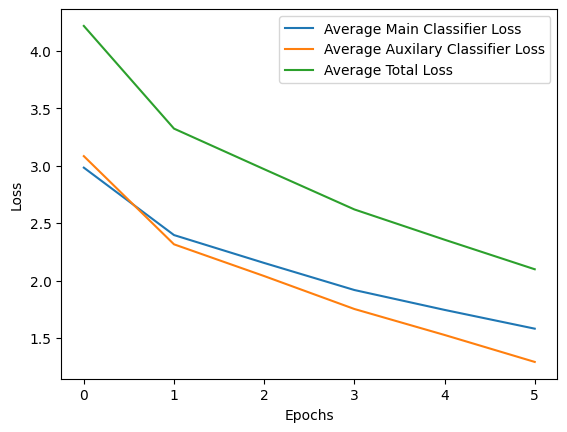

In [ ]:
#Define the loss function to determine the loss rate
loss_cal = nn.CrossEntropyLoss()
#Run the InceptionV3 model
model = InceptionV3Network()
#Train the model
train(model, loss_cal, learning_rate, train_loader, class_names, num_epochs)

#Evaluate the Inception V3 model accuracy

In [ ]:
#Evaulate the model
evaluate(model, val_loader, class_names)

Overall Accuracy over 3730 validation images: 46.27%
                                   precision    recall  f1-score   support

                            water       0.66      0.95      0.78       347
           pizza-margherita-baked       0.42      0.63      0.50        51
                         broccoli       0.51      0.79      0.62        28
           salad-leaf-salad-green       0.39      0.81      0.53       198
                              egg       0.51      0.39      0.44        80
                           butter       0.20      0.43      0.27       140
                      bread-white       0.64      0.53      0.58       245
                            apple       0.72      0.72      0.72        80
                   dark-chocolate       0.70      0.58      0.63        33
       white-coffee-with-caffeine       0.23      0.38      0.29        53
                     sweet-pepper       0.10      0.09      0.09        33
mixed-salad-chopped-without-sauce       0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Save the model into a file

In [ ]:
torch.save(model.state_dict(), 'Model.pth')
from google.colab import files
files.download('Model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>